# Unsupervised Anomaly Detection on Timeseries Data (NAB)

## Ethan Tucker

## 9/29/2022


# Introduction 

In preparation of a hopeful internship at the National Renewable Energy Laboratory (NREL) in Golden Colorado, I wish to gain experience in detecting anomalies in time series data through a variety of machine learning approaches. The primary goal of anomaly detection is to identify outliers in data. I read a [nice blog post](https://iwringer.wordpress.com/2015/11/17/anomaly-detection-concepts-and-techniques/) which gives a brief overview of different statistical and ML methods used for anomaly detection. While the summary included both supervised and unsupervised techniques, the NREL position is a cybersecurity one. It seems to me that supervised ML is of limited use; if we need to wait for new breeds of attacks/disruptions to be labelled in volume, we already failed to protect the energy grid. I will thus focus on unsupervised methods in this project. 


## Types of Anomalies

From the research I have done thus far, outliers usually fall into one of two camps:

1. Point outliers. When data are univariate (expected to originate from a specific probability distribution), we can create prediction intervals using either a theoretical or empirical distribution. Points beyond some number of standard deviations are labelled anomalous. In my statistics coursework, we have generally considered points 1.5 IQR above or below the mean to be outliers, and 3 IQR above/below to be extreme outliers. Maintainence of a moving average and moving variance allow detection mechanisms to work in a data stream / at scale. 

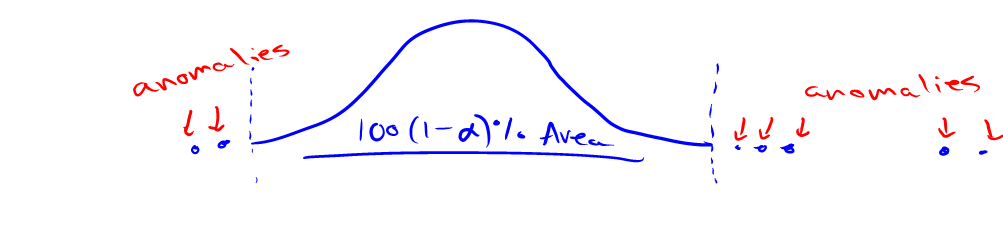

2. Functional outliers, referred to as "collective" in the blog post. These often occur in time-series data, and manifest as change-of-state, pattern breaking, and myriad other possibilities. I've included a quick sketch of a couple possible functional anomalies for clarity. In this project I will attempt to build ML models that are adept at identifying collective outliers, because periodic sensor data in a distributed energy system constitute functions. Disruptions in function values, or pattern breaking can indicate inefficiencies, breaks, and attacks. 

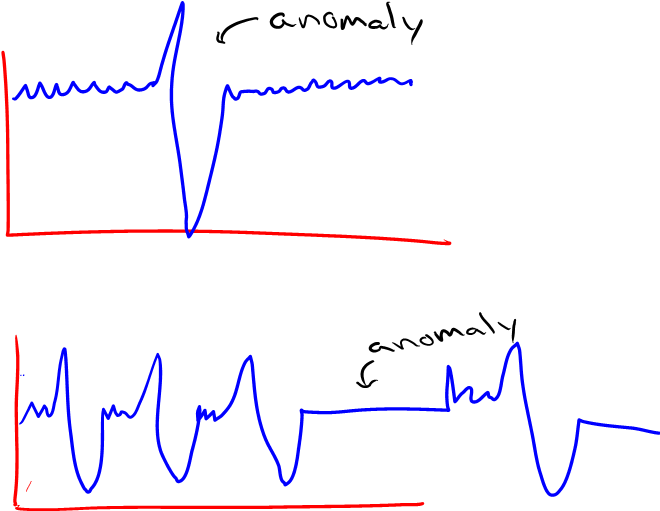

All unsupervised algorithms need to be tested on new data to ensure that the black-box is correctly identifying anomalies. That is to say, the ML is a data filtration tool which a human can use to drastically speed up response times to crises. Unsupervised ML should not be used as the sole method of classification - sometimes outages and level shifts are totally normal, and so a human should always review flagged events.


# The NAB Data

The Numenta Anomaly Benchmark (NAB) datasets consist of 58 open-source timeseries data files designed to train anomaly detection mechanisms. There are both real and synthetic data. I'll use a real one! Here are links to [the GitHub repo](https://github.com/numenta/NAB/tree/master/data) and [a Kaggle repo](https://www.kaggle.com/datasets/boltzmannbrain/nab?datasetId=110&sortBy=voteCount) that can be used to access the data. I will choose to do my project on the NAB/data/realKnownCause/machine_learning_system_failure.csv file, which contains two features: (1) a timestamp, and (2) the internal temperature of some industrial machine. The Kaggle repo claims that there exist three anomalies - the first and third are easily detectable, but the second is hard to find and directly led to the third. I will use a variety of ML algorithms in the aims of creating models that can detect all three anomalies.

The machine_learning_system_failure.csv data is germane to the work I will do at NREL - distributed energy systems report state by sensor, with features such as voltage, current, and temperature. Moreover sensor data is primarily time-series, and so the approach I undergo in this notebook can easily be applied elsewhere with some modification. Without further adeu, let's import the data and perform some EDA.

In [126]:
# Libraries for the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Classical ML approaches
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Deep learning approach. I'll use TensorFlow's Keras API to implement an RNN
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM

In [127]:
#Set working directory. Adapt for your build.
os.chdir("C:/Users/first/Desktop/Anomaly_Detection_Project")

In [128]:
# Import data, and clean column names
url = "https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/machine_temperature_system_failure.csv"
temp_df = pd.read_csv(url)
temp_df.columns = ["timestamp", "temperature"]
temp_df["timestamp"] = pd.to_datetime(temp_df["timestamp"])
# Get a feel for the dataset
print(temp_df.info())
temp_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22695 entries, 0 to 22694
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   timestamp    22695 non-null  datetime64[ns]
 1   temperature  22695 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 354.7 KB
None


,timestamp,temperature
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836


In [129]:
print("Earliest timestamp:", temp_df["timestamp"].min())
print("Latest timestamp:", temp_df["timestamp"].max())

print("Minimum temperature:", temp_df["temperature"].min())
print("Maximum temperature:", temp_df["temperature"].max())

Earliest timestamp: 2013-12-02 21:15:00
Latest timestamp: 2014-02-19 15:25:00
Minimum temperature: 2.084721206
Maximum temperature: 108.5105428


## Exploratory Data Analysis

The data have two columns: 

1. A timestamp. The timestamps range from 2013/12/02 at 21:15:00 to 2014/02/19 at 15:25:00. Timestamps are recorded every five minutes, and there are no missing values.

2. A "large industrial machine"'s internal temperature value recorded by the sensor. 

Before we do anything else, let's graph the columns against each other to get a general understanding of the entire dataset. I'll use R tidyverse's ggplot2 to generate graphics for speed and convenience. My .rmd in which I make ggplots will also be in the [GitHub repository containing this project](https://github.com/EthanJTucker/Unsupervised_Anomaly_Detection_Project). 

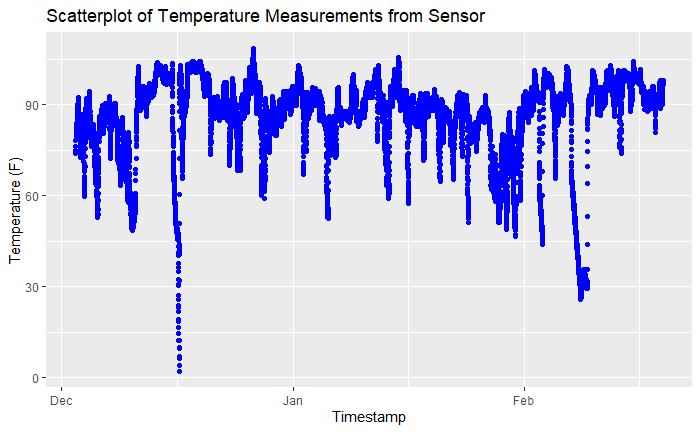

For comparison, here is the plot supplied in [Numenta's blogpost](https://numenta.com/neuroscience-research/research-publications/papers/unsupervised-real-time-anomaly-detection-for-streaming-data) wherein the paper initially analysing the data is sourced. 

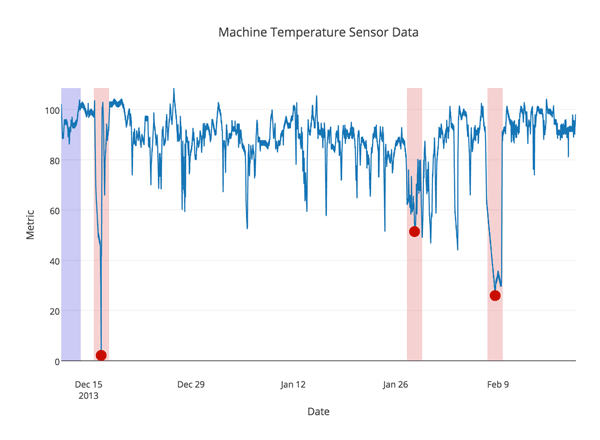

The regions in red indicate anomylous time periods. According to [figure one](https://www.sciencedirect.com/science/article/pii/S0925231217309864), the first anomaly was a planned shutdown, the second was a subtle change in the system's behavior which led to the third anomaly - a system failure. The goal of our ML implementations is to flag at least one timestamp in each of these regions, while flagging as few other timestamps as possible. It is worth noting that [the paper](https://www.sciencedirect.com/science/article/pii/S0925231217309864) is from 2017, before the widespread adoption of LSTM neural networks for anomaly detection. 

Before continuing on to modeling, let's look at a basic visualizations of the temperature feature:

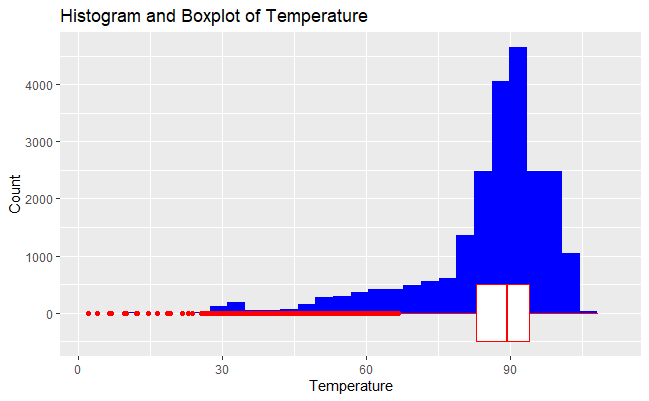

The distribution of temperature is very left skewed. All outliers identified by ggplot exist to the left of the IQR.

## Feature Engineering / Data Mining

The data pertain to the internal temperature of a large industrial machine. The scatterplot / lineplot in my EDA show the temperature of the machine seems very spikey, and most of those spikes do not indicate anomalies. What could cause spikes in usage? The most likely answer lies in features of the date / week. I'll create two new features from the timestamp:

1. Day of the week. I expect that weekdays may see a heavier workload for the machine than weekends. If there is no major difference in mean levels of weekdays and weekends, I'll conglomerate them into Weekday Vs. Weekend. If the sample means and sample variances are all comparable in this feature I'll nix it.

2. Daytime Vs. Nighttime. Lots of potential splits between "day" and "night" exist. I'm going to make it easy on myself and say that "day" begins at the mean sunrise in Michigan - approximately 8:00 AM, and sunset occurs at 8:00 PM. Again, if the sample mean and sample variances are comparable in this feature I'll nix it.

In [130]:
# Create useful features in dataframe.
temp_df["daytime"] = ((temp_df['timestamp'].dt.hour >= 8) & (temp_df['timestamp'].dt.hour < 20)).astype(int)
# Pandas considers day 0 to be monday, and day 6 to be sunday
temp_df["weekday"] = (temp_df['timestamp'].dt.dayofweek < 5).astype(int)

### A statistical interlude: is day/night meaningful?

In [131]:
#Inspect for an interaction between temperature and daytime
night_temps = temp_df[temp_df["daytime"] == 0]["temperature"]
day_temps = temp_df[temp_df["daytime"] == 1]["temperature"]

# Need counts to build confidence intervals. I don't just use N//2 because in some timeseries datasets data are missing at various time intervals.
n_night = len(night_temps)
n_day = len(night_temps)

print("The mean internal temperature during the day was: ", day_temps.mean(), "with standard deviation: ", day_temps.std())
print("Total daytime observations: ", n_day)
print("The mean internal temperature during the night was: ", night_temps.mean(), "with standard deviation: ", night_temps.std())
print("Total nighttime observations: ", n_night)

The mean internal temperature during the day was:  84.76786212130851 with standard deviation:  14.742350234262911
Total daytime observations:  11373
The mean internal temperature during the night was:  87.07993862252071 with standard deviation:  12.573584944254629
Total nighttime observations:  11373


#### Ratio of sample variances

The difference in means and standard deviations may be both statistically significant and practically significant. To make sure that the differences are statistically significant, we can do some basic hypothesis testing. Before testing the difference in means, we should first determine whether the sample variances are statistically distinct. If they are not, we will use a pooled variance for increased accuracy in the difference of means test.

I'll use an [F test](https://www.itl.nist.gov/div898/handbook/eda/section3/eda359.htm) to test the following hypotheses, where $\sigma_1$ is the daytime sd and $\sigma_2$ is the nighttime sd:

$$ H_0: \quad \sigma_1^2 = \sigma_2^2 $$

$$ H_1: \quad \sigma_1^2 \neq \sigma_2^2 $$

The test statistic will be $F_{n_2 - 1, n_1 - 1} := \sigma_2^2 / \sigma_1^2 $. We will reject the null hypothesis in favor of the alterative if:

$$ F_{\text{test}} < F_{1-\frac{\alpha}{2} , n_2 - 1, n_1 - 1} $$

As a little notation note - the $1 - \frac{\alpha}{2}$ indicates that we want to have that much area *to the right* of the F distribution. I'll set $\alpha = 0.05$ before testing. Other appropriate choices include $0.01$ and $0.001$ depending on context. This F test isn't the primary test, so I'm okay using a more lenient cutoff.

The test statistic $F_{\text{test}}$ works out to $0.7274$. R gives the cutoff value for the appropriate F distribution as $0.9588$. Because the test statistic falls into the rejection region, we reject the null hypothesis that the sample variances are indistinguishable. We will therefore not use a pooled variance test for difference of means.

### Difference of Means

The number of observations is much greater than 30, so we can use an approximate Z test for the difference in means. A well known theorem in statistics states that the sum of independent normal variables has a normal distribution:

$$ \text{N}(\mu_1, \sigma_1^2) + \text{N}(\mu_2, \sigma_2^2) \quad \sim \quad \text{N}(\mu_1 + \mu_2, \frac{\sigma_1^2}{n_1} + \frac{\sigma_2^2}{n_2})$$

The CLT let's us model the sample mean $\bar{x}$ with a normal distribution for sufficiently high $n$. As a side note, independence is probably unjustified by looking at the scatterplot - levels don't jump drastically between day/night cycles, so the values seem correlated. Lack of independence isn't critical, but is something to be cautious of when considering the results of the inference.

The hypotheses I'll test are:

$$ H_0: \quad \mu_1 = \mu_2 $$

$$ H_1: \quad \mu_1 \neq \mu_2 $$

The test statistic will be $\mu_1 - \mu_2$, with rejection region 

$$R^* = \quad \big\{\bar{x_1} - \bar{x_2} | \bar{x_1} - \bar{x_2} \not \in [\text{Z}_{1 - \frac{\alpha}{2}} \sqrt{\frac{\sigma_1^2}{n_1} + \frac{\sigma_2^2}{n_2}}, \text{Z}_{\frac{\alpha}{2}} \sqrt{\frac{\sigma_1^2}{n_1} + \frac{\sigma_2^2}{n_2}}] \big\}$$

where $Z_y$ indicates a standard normal quantile with y area to the right of the cutoff. Using the same value $\alpha = 0.05$ returns a rejection region:

$$R^* = \big\{\bar{x_1} - \bar{x_2} | \bar{x_1} - \bar{x_2} \not \in [-0.3561, 0.3561] \big\}$$

The difference $\bar{x_1} - \bar{x_2} = -2.312$ falls inside the rejection region, so we reject the null hypothesis in favor of the alternative. We therefore have reasonable evidence that the day/night split from 7:00 AM to 7:00 PM is a meaningful feature and can be used for anomaly detection. Now we repeat this process for the weekday / weekend split.

### Is weekday/weekend meaningful?

In [132]:
#Inspect for an interaction between temperature and daytime
weekend_temps = temp_df[temp_df["weekday"] == 0]["temperature"]
weekday_temps = temp_df[temp_df["weekday"] == 1]["temperature"]

# Need counts to build confidence intervals.
n_weekend = len(weekend_temps)
n_weekday = len(weekday_temps)

print("The mean internal temperature during weekdays was: ", weekday_temps.mean(), "with standard deviation: ", weekday_temps.std())
print("Total weekday observations: ", n_weekday)
print("The mean internal temperature on the weekend was: ", weekend_temps.mean(), "with standard deviation: ", weekend_temps.std())
print("Total weekend observations: ", n_weekend)

The mean internal temperature during weekdays was:  86.0830697294737 with standard deviation:  12.744009524585982
Total weekday observations:  16359
The mean internal temperature on the weekend was:  85.52224418985466 with standard deviation:  16.0431643426328
Total weekend observations:  6336


Running the same F test as before yields a cutoff value of $0.9596$ and a test statistic of $0.6310$. We therefore have reason to not use a pooled variance test. Convenient, because we get to use the same difference of means test. 

Running the same difference of means test yileds a rejection region of: 

$$R^* = \big\{\bar{x_1} - \bar{x_2} | \bar{x_1} - \bar{x_2} \not \in [-0.4407, 0.4407] \big\}$$

The difference $\bar{x_1} - \bar{x_2} = 0.5609$, which lies in the rejection region. We have reason to believe that weekday/weekend is a meaningful distinction.

### Commentary:

We have two two-level factors, which combines to a total of four categories:

1. (weekday, day)

2. (weekday, night)

3. (weekend, day)

4. (weekend, night)

While many other categories certainly exist, these four provide a nice jumping off point into the data. Other meaningful splits that future research could address include month splits, specific day of week splits, fiscal quarter splits, and different day/night splits (even by hour). I chose to keep the number of categories low in order to maintain larger counts per category, and to make interpretation easier.

# ML Implementation:

#### Metrics Note

Anomalies that can result in total system failure (such as the second anomaly in this data) are very important to detect. Accuracy is an awful metric for anomaly detection - we could reach an amazing accuracy by simply labelling no points as anomalous. Precision isn't great either, because we care less about false positives than potentially missing a true positive. That said, it can be expensive to pay a technician to go check anomalies that are false positives. We want enough positive anomaly detections in anomalous regions that we are confident we won't miss regions altogether, while minimizing false positives. Additionally, false positives stacked near each other can be counted as a single false positive, because they will be collectively investigated by a human. The metric of choice then is some mixture of recall and F1 score.. To let the unsupervised ML models have a "fair shot" at optimizing recall, we should let them make quite a few positive predictions. We know a-posteriori that there exist three regions of anomylous points (see EDA). I'll classify a success as any point in a region getting flagged.

# Principal Component Analysis

I'll perform Principal Component Analysis on the timestamp, temperature, and features that were data mined in order to create some uncorellated features. Below I include a graphic explaining how anomalies are detected using PCA.

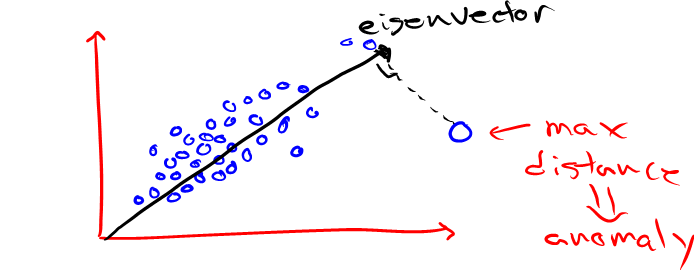

The above exemplifies the first eigenvector (principal component) of a two dimensional dataset. The eigenvector can be thought of the "axis" which minimizes distance between all data points. In the context of anomaly detection, the "weirdest" datapoint will therefore have the farthest distance from the eigenvector. We can perform PCA over all dimensions of our dataset, and use a k-dimensional euclidean distance to classify anomalies. I'll optimize over the number of anomalies where recall is the target metric. I'll also try F1 score to prevent overfitting. Side note - performing PCA also has the added benefit of de-correlating the data features, which is critical with multiple temporal features.

In [133]:
# First standardize the data. 
# Standard Scaler doesn't auto-scale timestamps intelligently, so we need to break them up into components
# The data are only over the course of 3 months, so the highest level time value there is sufficient data to differentiate is day of month. I'll also do hour and minute as time features.
temp_df["day_of_month"] = temp_df["timestamp"].dt.day
temp_df["hour_of_day"] = temp_df["timestamp"].dt.hour
temp_df["minute_of_hour"] = temp_df["timestamp"].dt.minute #This is fine to scale because the set of unique values is symmetric

cluster_features = ["temperature", "day_of_month", "hour_of_day", "minute_of_hour", "weekday", "daytime"]
data = StandardScaler().fit_transform(temp_df[cluster_features])

# Perform principal component analysis to un-corellate temporal features 
# Note that sending data to the eigenspace will un-standardize, so we will need to re-standardize
data = PCA(n_components = 6).fit_transform(data)
scaled_pca_data = StandardScaler().fit_transform(data)


print("The scaled PCA data has shape: ", scaled_pca_data.shape)

The scaled PCA data has shape:  (22695, 6)


In [134]:
# Make anomaly predictions using PCA

def euclideanDistance(data : np.ndarray) -> np.ndarray:
    """
        This function takes in a scaled np.ndarray data and computes the k-dimensional
        euclidean distance for each row. All columns must contain float data.
        Returns np.ndarray vector of shape (n_rows, )
    """
    n = data.shape[0]
    j = data.shape[1]
    container = np.zeros(n)
    sqd_data = data**2
    for i in range(n):
        container[i] = sqd_data[i, ].sum()
        
    return(container)
        
n = scaled_pca_data.shape[0]
distance_df = pd.DataFrame(euclideanDistance(scaled_pca_data))
distance_df["index"] = [i for i in range(n)]
distance_df.columns = ["distance", "index"]

#Pick the desired number of anomalies as the integer input to .head()
PCA_anomalies = distance_df.sort_values("distance", ascending = False).head(400)["index"]

#Uncomment this if you want to download the Anomaly predictions 
#temp_df.iloc[PCA_anomalies].to_csv("./PCA_Anomalies.csv")

### PCA Optimization:

The hyperparameter to be optimized in PCA is the euclidean distance cutoff beyond which we classify an anomaly. By rough visual inspection there are around 1000 timestamps that are true anomalies. We will examine various cutoff values graphically, then pick one based on heuristic reasoning as our final PCA model.

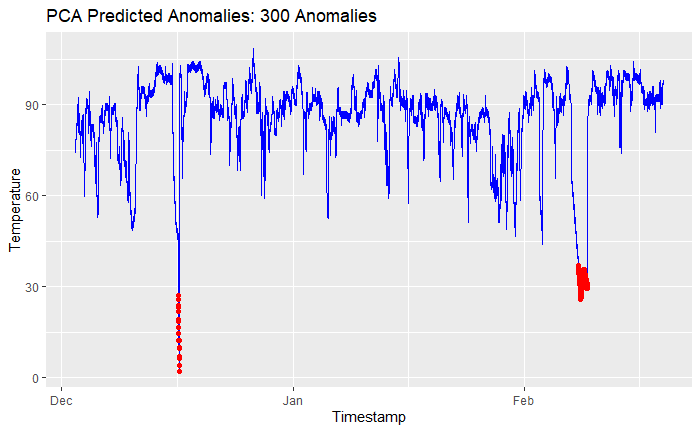

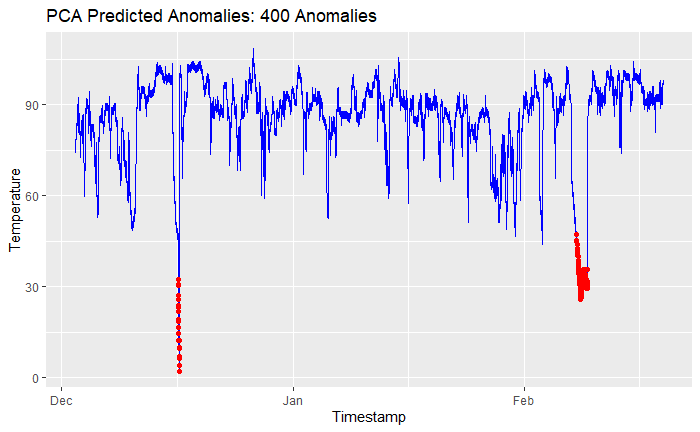

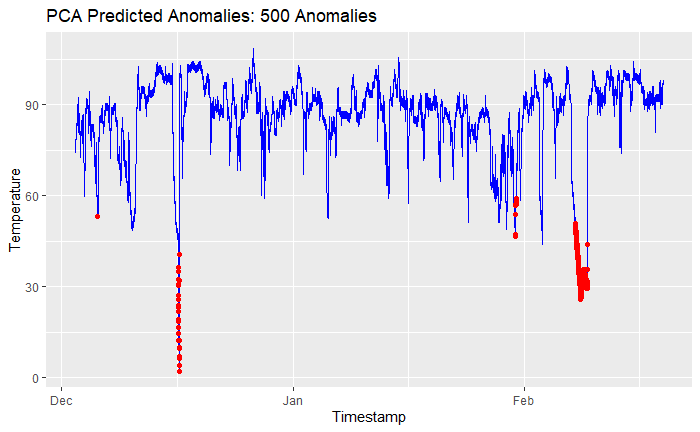

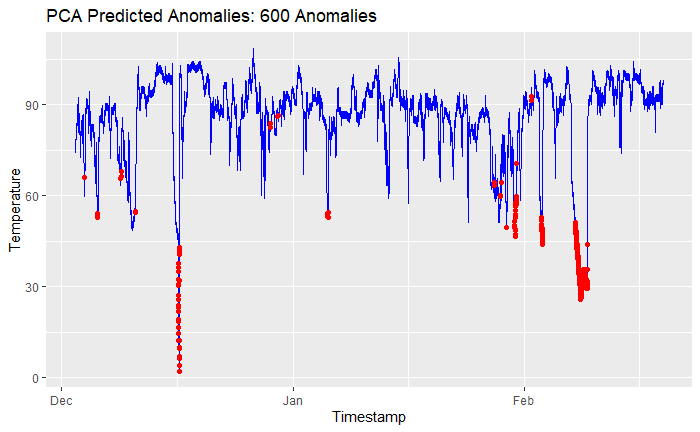

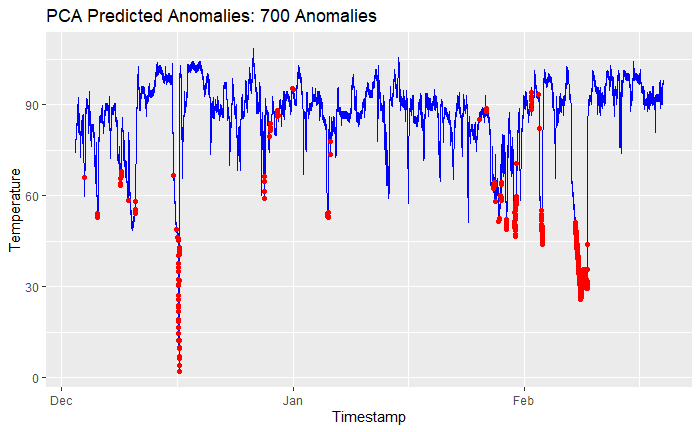

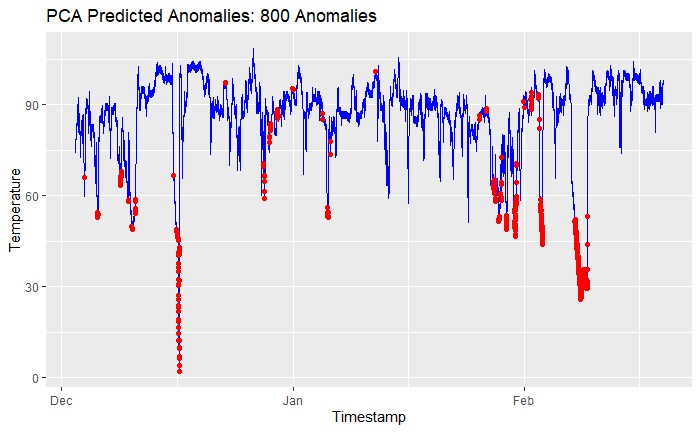

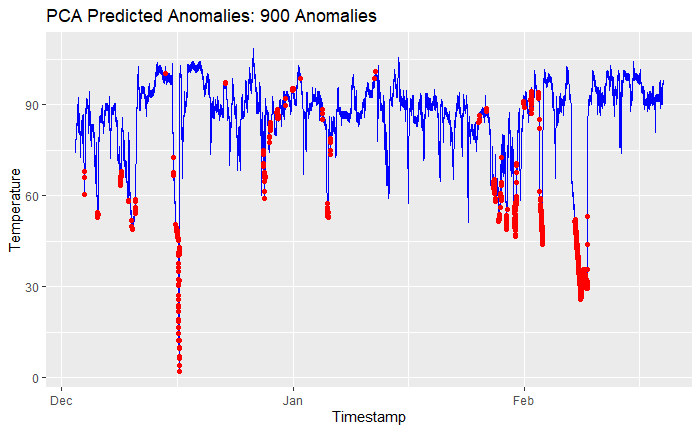

#### Commentary:

The PCA manages to weakly tag all three anomalous regions with very high precision at 500 anomalies. 700 or 800 seems like the optimal value balancing precision with recall. Beyond 1000 anomalies there are so many false positives that a human review would be very expensive, to the point that the anomaly detection is all but pointless. To detect an anomaly in a data stream, we map the data to the scaled eigenspace, then flag it if the distance is greater than or equal to the threshold.

[The complexity of PCA](https://alekhyo.medium.com/computational-complexity-of-pca-4cb61143b7e5) is $O(n\times m)$, which is excellent as long as $m << n$. Refactoring is not too expensive, and might be avoided altogether if the original eigenvectors are computed with sufficiently large $n$.

In [135]:
# Retrieve distance metrics for 500, 700 anomalies
PCA_HPs = distance_df.sort_values("distance", ascending = False).iloc[[500, 700]]["distance"]

print("The euclidean distance threshold in standardized eigenspace with 500 anomalies was:", round(PCA_HPs.iloc[0], 4))
print("The euclidean distance threshold in standardized eigenspace with 700 anomalies was:", round(PCA_HPs.iloc[1], 4))

The euclidean distance threshold in standardized eigenspace with 500 anomalies was: 14.2061
The euclidean distance threshold in standardized eigenspace with 700 anomalies was: 11.8856


# Clustering: K-Means

The concept behind K-Means is to sort all data into K clusters. K needs be chosen as a hyper-parameter, and should have some reasonable interpretation. For univariate data like "temperature", an initial thought is seperate data into two camps: standard vs. anomalous. The primary issue is that the anomalous temperatures are not always distinct by value from non-anomalous ones. That is to say, sometimes a temperature measurement of 70 will be anomalous, but sometimes it won't. Our machine learning algorithm needs to distinguish between these cases. A better way to detect anomalies with K-Means involves some feature engineering. By splitting up our timestamps into the four categories that we have, we can classify anomalies as the data points that are farthest from their respective centroids. 

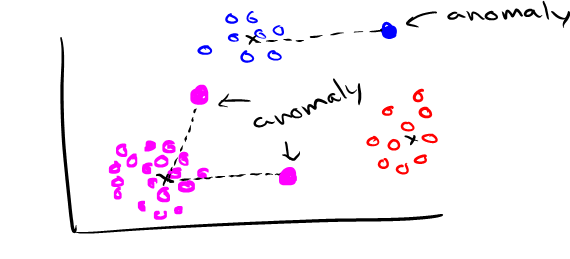

The decision mechanism of a K-Means anomaly detector is similar to that of PCA - in fact PCA is a special case of the K-Means mechanism with K = 1. We will map all the data to the eigenspace, then compute euclidean distance from correct centroid for each datum. The largest distances become the anomaly predictions.

The plan of attack is to ue the four statistically justified clusters. This is helpful to prevent anomalies that "truly" belong to one cluster being sufficiently close to another and avoiding detection. Future research should try other values of K using Sk-Learn. There is no reason to assume the four categories I datamined are the optimal splits.

In [136]:
%%capture
# We can use the extant scaled PCA data, then filter into four subsets
temp_df["index"] = [i for i in range(n)]
weekend_nights = list(temp_df[temp_df["daytime"] == 0][temp_df["weekday"] == 0]["index"])
weekend_days = list(temp_df[temp_df["daytime"] == 1][temp_df["weekday"] == 0]["index"])
weekday_nights = list(temp_df[temp_df["daytime"] == 0][temp_df["weekday"] == 1]["index"])
weekday_days = list(temp_df[temp_df["daytime"] == 1][temp_df["weekday"] == 1]["index"])

In [137]:
def getCentroid(data : np.ndarray) -> np.ndarray:
    """
        Function which computes the centroids for clusters.
        Input: filtered dataset data. Should be standardized PCA dataset
        Output: centroid np.ndarray vector of shape(m, )
    """
    m = data.shape[1]
    container = np.zeros(m)
    for j in range(m):
        container[j] = data[:, j].mean()
        
    return(container)

weekend_nights_centroid = getCentroid(scaled_pca_data[weekend_nights])
weekend_days_centroid = getCentroid(scaled_pca_data[weekend_days])
weekday_nights_centroid = getCentroid(scaled_pca_data[weekday_nights])
weekday_days_centroid = getCentroid(scaled_pca_data[weekday_days])

In [139]:
%%capture
# This function computes the euclidean distance between data and a centroid.
def adjustedEuclideanDistance(data : np.ndarray, centroid : np.ndarray) -> np.ndarray:
    """
        Computes distance metric for supplied data and centroid. Data should be a standardized
        PCA dataset, and the centroid should be the corresponding centroid.
        Output: np.ndarray vector distances of shape (n, )
    """
    container = sum(np.transpose((data - centroid)**2))
    return(container)

#insertion runs in O(n) - this might be sped up with a maxHeap somehow. I doubt that though.
distance_df = temp_df[["temperature", "timestamp"]]
distance_df["KMeans_distance"] = [float(-1) for i in range(n)]
distance_df["KMeans_distance"].iloc[weekend_nights] = adjustedEuclideanDistance(scaled_pca_data[weekend_nights], weekend_nights_centroid)
distance_df["KMeans_distance"].iloc[weekend_days] = adjustedEuclideanDistance(scaled_pca_data[weekend_days], weekend_days_centroid)
distance_df["KMeans_distance"].iloc[weekday_nights] = adjustedEuclideanDistance(scaled_pca_data[weekday_nights], weekday_nights_centroid)
distance_df["KMeans_distance"].iloc[weekday_days] = adjustedEuclideanDistance(scaled_pca_data[weekday_days], weekday_days_centroid)

# Make sure that we correctly computed a distance metric for each datum
assert float(-1) not in distance_df["KMeans_distance"].unique()

In [140]:
# Make anomaly predictions using KMeans
n_anomalies = 900
# Write predictions to a csv if desired
#distance_df.sort_values("KMeans_distance", ascending = False).head(n_anomalies).to_csv("./KMeans_Anomalies.csv")

### KMeans model comparisons

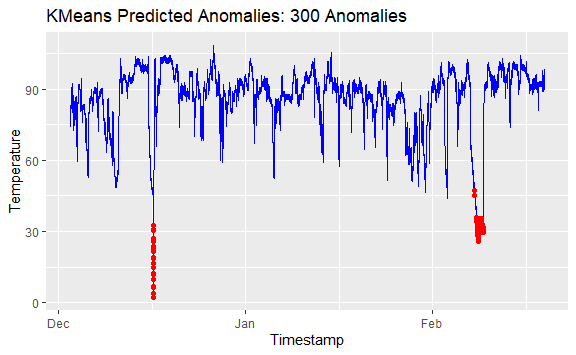

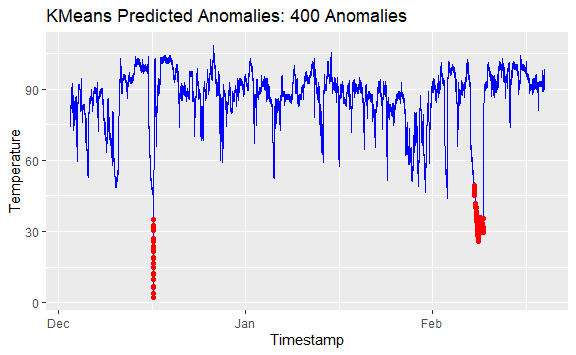

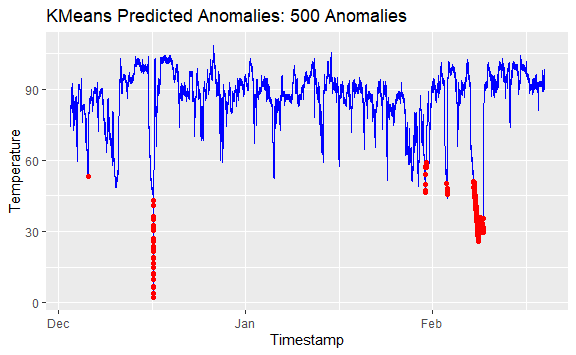

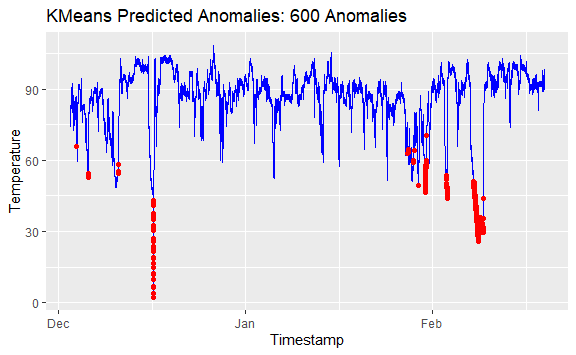

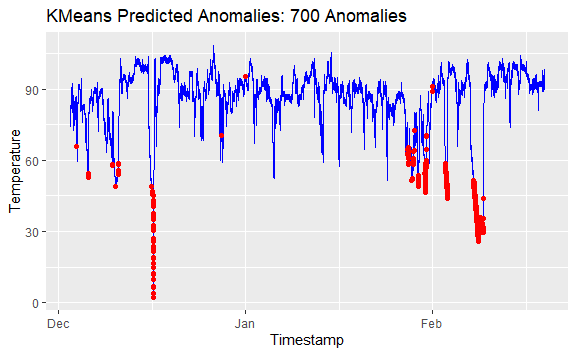

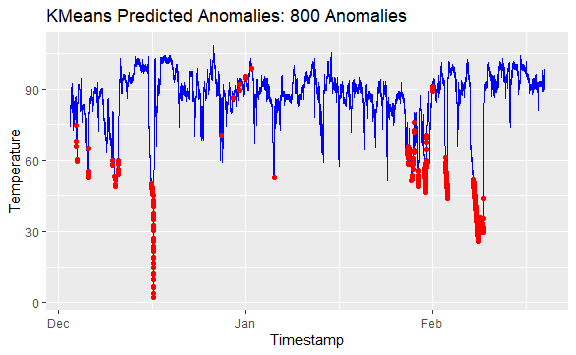

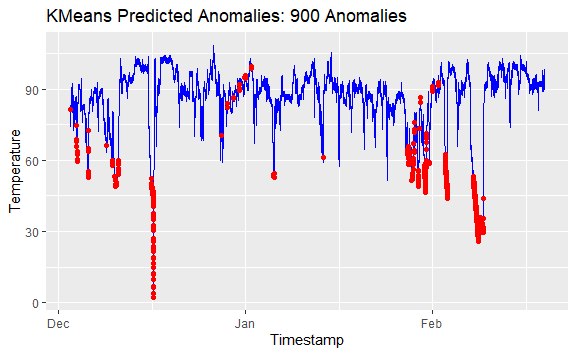

### Commentary:

I think either the 500 anomaly model or the 600 anomaly models are best. The 500 model has many fewer misclassifications, but does not pick up the breadth of anomaly two. The 600 model has more misclassifications but can see a wider range of anomalies in anomaly two. I would probably pick the 600 model and have a running decaying anomaly count that triggers further action. Let's get the euclidean distances for the 500 and 600 anomaly models.

In [142]:
# Retrieve distance metrics for 500, 700 anomalies
KMeans_HPs = distance_df.sort_values("KMeans_distance", ascending = False).iloc[[500, 600]]["KMeans_distance"]

print("The euclidean distance threshold in standardized eigenspace with 500 anomalies was:", round(KMeans_HPs.iloc[0], 4))
print("The euclidean distance threshold in standardized eigenspace with 600 anomalies was:", round(KMeans_HPs.iloc[1], 4))

The euclidean distance threshold in standardized eigenspace with 500 anomalies was: 12.2734
The euclidean distance threshold in standardized eigenspace with 600 anomalies was: 10.9438


# Recurrent Neural Network (RNN)

# Bibliography

1. Subutai Ahmad, Alexander Lavin, Scott Purdy, Zuha Agha, Unsupervised real-time anomaly detection for streaming data, Neurocomputing, Volume 262, 2017, Pages 134-147, ISSN 0925-2312, https://doi.org/10.1016/j.neucom.2017.04.070. (https://www.sciencedirect.com/science/article/pii/S0925231217309864)

2. https://iwringer.wordpress.com/2015/11/17/anomaly-detection-concepts-and-techniques/

3. https://medium.com/bukalapak-data/time-series-anomaly-detection-simple-yet-powerful-approaches-4449ffe1ca12

4. https://scikit-learn.org/stable/auto_examples/applications/plot_outlier_detection_wine.html#sphx-glr-auto-examples-applications-plot-outlier-detection-wine-py

5. https://visualstudiomagazine.com/articles/2021/10/20/anomaly-detection-pca.aspx

6. https://numenta.com/neuroscience-research/research-publications/papers/unsupervised-real-time-anomaly-detection-for-streaming-data

7. https://www.itl.nist.gov/div898/handbook/eda/section3/eda359.htm

8. https://alekhyo.medium.com/computational-complexity-of-pca-4cb61143b7e5